## TEAM NAME: QUANTUM ENTANGLERS

### Team Members

**Rajana Rama Satya Sai Durga Prasad**  
**Enrollment ID:** WQ24-UkA0PEQyOfbIQTn  
**Email:** rajanasatyasai@gmail.com

**Sunita**  
**Enrollment ID:** WQ24-kntLxdjlEEqKqC9  
**Email:** khothsunita1508@gmail.com

### Project: QML-for-Conspicuity-Detection-in-Production


## **TASK 2 - Variational Classifier**


## **Imports - Pennylane used for Quantum Machine Learning**


In [3]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

Quantum and Classical nodes
===========================
```python
Next, we create a quantum device to execute our circuits.
```

In [4]:
dev = qml.device("default.qubit")

In this circuit, each qubit undergoes a rotation defined by three parameters, followed by CNOT operations between the different qubits, except between qubits 1 and 3. This structure can be repeated multiple times, and increasing the number of layers provides more degrees of freedom.

The layer function applies a layer of operations to a set of four qubits:

- **Rotation (ROT)**: Each qubit undergoes a rotation defined by three parameters.
- **CNOT**: CNOT gates are applied between adjacent qubits (0-1, 1-2, 2-3) and between qubits 3 and 0, forming a circular connection.


In [5]:
def layer(layer_weights):
    for wire in range(4):
        qml.Rot(*layer_weights[wire], wires=wire)

    for wires in ([0, 1], [1, 2], [2, 3], [3, 0]):
        qml.CNOT(wires)

One of the primary challenges we'll encounter is the need to encode data. There are various strategies for this, depending on our data. In this first example, we use the basis state encoding method, which translates binary values into quantum states. Specifically, this method uses 4 qubits to represent any data point in the dataset. However, a limitation of this approach is the finite number of values it can represent; with 4 qubits, we can represent \(2^4 = 16\) values. Thus, with \(n\) qubits, we can represent \(2^n\) values.

The `state_preparation` function prepares a quantum state by setting qubits 0, 1, 2, and 3 to the basis state defined by the binary values in the input `x`. This method translates the binary representation of `x` into the corresponding quantum state of the qubits.


In [6]:
def state_preparation(x):
    qml.BasisState(x, wires=[0, 1, 2, 3])

After we have defined the encoding and the repetitive structure or structures that we will use, we can create our circuit. In this case, it is pretty simple: first the encoding layer `state_preparation()` and our trainable `layer()`. After defining that, we can take the expected value of the Pauli-Z operator.

The `circuit` function performs the following steps:

1. Prepares the initial state of the qubits using the `state_preparation` function with the input `x`.
2. Applies a series of layers to the qubits, where each layer consists of rotation and CNOT operations defined by the weights in `weights`.
3. Measures and returns the expectation value of the Pauli-Z operator on qubit 0.

The `@qml.qnode(dev)` decorator ensures that this function can be executed on a quantum device specified by `dev`.


In [7]:
@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)

    for layer_weights in weights:
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0))

Here, we define our model. It's currently determined by the weights and bias, but we have the potential to make it more adaptable.

The `variational_classifier` function performs the following steps:

1. Executes the quantum circuit with the given weights and input data `x`, obtaining an expectation value.
2. Adds the bias to the result of the quantum circuit.

This function effectively combines the output of a variational quantum circuit with a classical bias term to produce the final output of the classifier.



In [8]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

Also we have to define 3 important parts of a model, the cost function, our metric, and a loss function.

Here as a loss function we use the square loss or also known as Mean square error

The square_loss function calculates the mean squared error between the true labels and the predictions. It first uses qml.math.stack to ensure the predictions are in a suitable format for element-wise subtraction. Then, it computes the squared differences between the labels and predictions and returns the mean of these squared differences. This metric is commonly used to evaluate the performance of regression models.

In [9]:
def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

Next, we define a metric that provides a human-readable and interpretable value for evaluating the performance of the model. There are many metrics available, but for simplicity, we will use accuracy in this example.

The `accuracy` function computes the accuracy of predictions compared to true labels by following these steps:

1. Pairs each true label with its corresponding prediction.
2. Checks if the absolute difference between each label and prediction is less than a small threshold (1e-5), counting these as correct predictions.
3. Sums up the number of correct predictions.
4. Divides the number of correct predictions by the total number of labels to calculate the accuracy.
5. Returns the accuracy as a proportion (a value between 0 and 1), where 1 indicates perfect accuracy.


In [10]:
def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

In the end, we defined our cost function, which is used to train the model. With this function, the gradients are calculated and help the model to move in the right direction.

The cost function computes the cost (or loss) of the predictions made by a variational classifier. It does this by:

1. Generating predictions for each input in `X` using the `variational_classifier`.
2. Calculating the squared loss between the true labels `Y` and these predictions.
3. If you have any specific questions about this code or need further details on the `variational_classifier` or `square_loss` functions.


In [11]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

## **Optimization of the model**

We collect the data to optimize the model. By using `np.loadtxt()`, we can retrieve data from various sources, such as a URL or a local directory.

**Code snippet:**

- Loads training data from a specified URL.
- Splits the data into feature vectors (`X`) and labels (`Y`).
- Transforms the labels from {0, 1} to {-1, 1}.
- Prints each feature vector and its corresponding label.


```

In [12]:
data = np.loadtxt("https://raw.githubusercontent.com/XanaduAI/qml/master/_static/demonstration_assets/variational_classifier/data/parity_train.txt", dtype=int)
X = np.array(data[:, :-1])
Y = np.array(data[:, -1])
Y = Y * 2 - 1  # shift label from {0, 1} to {-1, 1}

for x,y in zip(X, Y):
    print(f"x = {x}, y = {y}")

x = [0 0 0 1], y = 1
x = [0 0 1 0], y = 1
x = [0 1 0 0], y = 1
x = [0 1 0 1], y = -1
x = [0 1 1 0], y = -1
x = [0 1 1 1], y = 1
x = [1 0 0 0], y = 1
x = [1 0 0 1], y = -1
x = [1 0 1 1], y = 1
x = [1 1 1 1], y = -1


In this part of the code, certain variables are defined to ensure reproducibility, specifically the weights and the bias value.

- Sets a random seed for reproducibility.
- Defines the number of qubits and layers.
- Initializes the weights with small random values and sets them as trainable.
- Initializes the bias to 0 and sets it as trainable.
- Prints the initialized weights and bias.
```


In [13]:
np.random.seed(0)
num_qubits = 4
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers + 1, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print("Weights:", weights_init)
print("Bias: ", bias_init)

Weights: [[[ 0.01764052  0.00400157  0.00978738]
  [ 0.02240893  0.01867558 -0.00977278]
  [ 0.00950088 -0.00151357 -0.00103219]
  [ 0.00410599  0.00144044  0.01454274]]

 [[ 0.00761038  0.00121675  0.00443863]
  [ 0.00333674  0.01494079 -0.00205158]
  [ 0.00313068 -0.00854096 -0.0255299 ]
  [ 0.00653619  0.00864436 -0.00742165]]

 [[ 0.02269755 -0.01454366  0.00045759]
  [-0.00187184  0.01532779  0.01469359]
  [ 0.00154947  0.00378163 -0.00887786]
  [-0.01980796 -0.00347912  0.00156349]]]
Bias:  0.0


Any model optimized using gradient descent techniques requires an optimizer. There are many optimizers available, such as Adam, Adagrad, pure gradient descent, and Momentum. In PennyLane, many of these optimizers are implemented.

In PennyLane, you have access to a variety of gradient descent optimizers to suit different needs. Some of the commonly used optimizers include:

- **Adam**: Combines the advantages of two other extensions of stochastic gradient descent, namely AdaGrad and RMSProp.
- **Adagrad**: Adapts the learning rate to the parameters, performing larger updates for infrequent and smaller updates for frequent parameters.
- **Gradient Descent**: The basic form of gradient descent where the learning rate is constant.
- **Momentum**: Accelerates gradient descent by taking into account the previous gradients to smooth out the updates.


```

In [14]:
opt = NesterovMomentumOptimizer(0.5)
batch_size = 5

We enter the optimization (training) loop. A key point to observe is that the predictions are processed using the `np.sign()` function. This function transforms the model’s output into definitive predictions: negative values become -1, while positive values are converted to +1.

**Code Explanation**

- Initializes the weights and bias.
- Runs an optimization loop for 100 iterations.
- In each iteration:
  - Selects a random batch of data.
  - Updates the weights and bias using the optimizer.
  - Computes predictions for the entire dataset.
  - Calculates the current cost and accuracy.
  - Prints the iteration number, cost, and accuracy.
y.
```


In [15]:
weights = weights_init
bias = bias_init
for it in range(100):
    

    # Update the weights by one optimizer step, using only a limited batch of data
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias = opt.step(cost, weights, bias, X=X_batch, Y=Y_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]

    current_cost = cost(weights, bias, X, Y)
    acc = accuracy(Y, predictions)

    print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")

Iter:    1 | Cost: 1.1982077 | Accuracy: 0.7000000
Iter:    2 | Cost: 1.1921779 | Accuracy: 0.7000000
Iter:    3 | Cost: 1.1987324 | Accuracy: 0.7000000
Iter:    4 | Cost: 1.5155498 | Accuracy: 0.7000000
Iter:    5 | Cost: 2.1271257 | Accuracy: 0.6000000
Iter:    6 | Cost: 1.1453663 | Accuracy: 0.7000000
Iter:    7 | Cost: 1.3368889 | Accuracy: 0.7000000
Iter:    8 | Cost: 0.7963113 | Accuracy: 0.7000000
Iter:    9 | Cost: 0.8854933 | Accuracy: 0.6000000
Iter:   10 | Cost: 1.3504250 | Accuracy: 0.6000000
Iter:   11 | Cost: 1.2998483 | Accuracy: 0.5000000
Iter:   12 | Cost: 0.8223170 | Accuracy: 0.6000000
Iter:   13 | Cost: 0.3572720 | Accuracy: 1.0000000
Iter:   14 | Cost: 0.1879121 | Accuracy: 1.0000000
Iter:   15 | Cost: 0.3486388 | Accuracy: 0.9000000
Iter:   16 | Cost: 0.3620678 | Accuracy: 0.9000000
Iter:   17 | Cost: 0.4004274 | Accuracy: 0.9000000
Iter:   18 | Cost: 0.2359822 | Accuracy: 1.0000000
Iter:   19 | Cost: 0.0656729 | Accuracy: 1.0000000
Iter:   20 | Cost: 0.0277633 | 

In [16]:
weights , bias

(tensor([[[ 1.76405235e-02,  1.56484980e+00,  1.00080245e-02],
          [ 2.24089320e-02,  3.16170916e+00,  4.02908735e-01],
          [ 9.50088418e-03,  3.41470299e-03,  3.04599463e-02],
          [ 4.10598502e-03, -1.55724469e+00,  7.64965615e-03]],
 
         [[ 2.44473266e-01,  1.05245593e-01, -2.34665335e-01],
          [-1.10873587e-02,  1.57612140e+00, -8.42912778e-01],
          [ 3.41876345e-02,  4.84829423e-01, -3.14490145e-02],
          [ 5.11879509e-01,  1.54553109e+00,  1.14052497e-02]],
 
         [[ 2.26975462e-02, -1.45436567e-02,  4.57585173e-04],
          [-3.44770945e-03,  1.55500423e+00,  1.46935877e-02],
          [ 7.77643950e-01,  2.52039292e-03, -8.87785748e-03],
          [ 1.67189905e-02,  1.58347435e+00,  1.56348969e-03]]], requires_grad=True),
 tensor(0.00067284, requires_grad=True))

**Evaluation**

- Similar to machine learning, we aim to evaluate how well our model generalizes. This involves testing the model on unseen examples, which is achieved using test data.

- Loads test data from a specified URL.
- Splits the data into feature vectors (`X_test`) and labels (`Y_test`).
- Transforms the labels from {0, 1} to {-1, 1}.
- Generates predictions for the test data using the trained variational classifier.
- Prints each feature vector, its true label, and its predicted label.
- Calculates and prints the accuracy of the model on the test data.

```


In [17]:
data = np.loadtxt("https://raw.githubusercontent.com/XanaduAI/qml/master/_static/demonstration_assets/variational_classifier/data/parity_test.txt", dtype=int)
X_test = np.array(data[:, :-1])
Y_test = np.array(data[:, -1])
Y_test = Y_test * 2 - 1  # shift label from {0, 1} to {-1, 1}
    
predictions_test = [np.sign(variational_classifier(weights, bias, x)) for x in X_test]

for x,y,p in zip(X_test, Y_test, predictions_test):
    print(f"x = {x}, y = {y}, pred={p}")
    
acc_test = accuracy(Y_test, predictions_test)
print("Accuracy on unseen data:", acc_test)

x = [0 0 0 0], y = -1, pred=-1.0
x = [0 0 1 1], y = -1, pred=-1.0
x = [1 0 1 0], y = -1, pred=-1.0
x = [1 1 1 0], y = 1, pred=1.0
x = [1 1 0 0], y = -1, pred=-1.0
x = [1 1 0 1], y = 1, pred=1.0
Accuracy on unseen data: 1.0


# Iris classification

This tutorial also demonstrated how to train a model for even more complex data. In this case, the encoding of the data was done based on the next code, which converts any vector `X` into another vector `W` composed of pure angles.

**Function `get_angles(x)`**
- **Purpose**: Computes a set of angles based on the input vector `x`.

**Steps for the code**:
1. Calculates three angles (`beta0`, `beta1`, `beta2`) using the `arcsin` function and norms of parts of `x`.
2. Returns an array of these angles, with some adjustments.

**Function `state_preparation(a)`**
- **Purpose**: Prepares a quantum state using the angles `a`.

**Steps**:
1. Applies a series of quantum gates (`RY`, `CNOT`, `PauliX`) to the qubits.
2. Uses the angles from `a` to rotate the qubits and entangle them.
hem.
```

In [18]:
def get_angles(x):
    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(np.linalg.norm(x[2:]) / np.linalg.norm(x))

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])


def state_preparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

This code demonstrates how to transform a classical input vector into a quantum state using angle encoding and then retrieve the resulting quantum state.

1. **Initialization**:
    
    - Initializes a 4-dimensional input vector `x`.
    - Computes angles `ang` based on `x` using the `get_angles` function.

2. **Quantum Node Definition**:

    - Defines a quantum node `test` that prepares a quantum state using the `state_preparation` function and returns the quantum state.

3. **Execution and Output**:
    
    - Executes the quantum node with the computed angles.
    - Prints the original input vector `x`, the computed angles `ang`, and the real part of the amplitude vector of the quantum state.
ctor of the quantum state.



In [19]:
x = np.array([0.53896774, 0.79503606, 0.27826503, 0.0], requires_grad=False)
ang = get_angles(x)


@qml.qnode(dev)
def test(angles):
    state_preparation(angles)

    return qml.state()


state = test(ang)

print("x               : ", np.round(x, 6))
print("angles          : ", np.round(ang, 6))
print("amplitude vector: ", np.round(np.real(state), 6))

x               :  [0.538968 0.795036 0.278265 0.      ]
angles          :  [ 0.563975 -0.        0.       -0.975046  0.975046]
amplitude vector:  [ 0.538968  0.795036  0.278265 -0.      ]


As before, we need to define our layers, circuit, and cost function. In this case, the metric was not redefined because we are using the same one as before.
0### `layer` Function
- **Purpose**: Applies a layer of quantum operations to two qubits.
- **Operations**:
  - **Rotation Gates**: Uses weights to apply rotation gates to each qubit.
  - **CNOT Gate**: Applies a CNOT gate between qubits 0 and 1.

### `cost` Function
- **Purpose**: Calculates the cost (or loss) of predictions made by the variational classifier.
- **Operations**:
  - **Transpose Input Data**: Ensures the input data is correctly formatted.
  - **Predictions**: Generates predictions using the variational classifier.
  - **Calculate Loss**: Computes the mean squared error between true labels and predictions.
, 1])



In [20]:
def layer(layer_weights):
    for wire in range(2):
        qml.Rot(*layer_weights[wire], wires=wire)
    qml.CNOT(wires=[0, 1])


def cost(weights, bias, X, Y):
    # Transpose the batch of input data in order to make the indexing
    # in state_preparation work
    predictions = variational_classifier(weights, bias, X.T)
    return square_loss(Y, predictions)

We collect the data and perform several transformations. Initially, we convert 2-dimensional vectors into 4-dimensional ones. Then, we normalize these vectors. Lastly, we use angle encoding to transform the data into 5-dimensional vectors.

- **Load Data**: Loads the dataset and extracts the first two columns as feature vectors \( \mathbf{X} \).
- **Pad Vectors**: Pads each feature vector to size 4 by adding two constant values (0.1).
- **Normalize Vectors**: Normalizes each padded vector.
- **Compute Angles**: Computes angles for state preparation from the normalized vectors.
- **Extract Labels**: Extracts the labels from the last column of the dataset.



In [21]:
data = np.loadtxt("https://raw.githubusercontent.com/XanaduAI/qml/master/_static/demonstration_assets/variational_classifier/data/iris_classes1and2_scaled.txt")
X = data[:, 0:2]
print(f"First X sample (original)  : {X[0]}")

# pad the vectors to size 2^2=4 with constant values
padding = np.ones((len(X), 2)) * 0.1
X_pad = np.c_[X, padding]
print(f"First X sample (padded)    : {X_pad[0]}")

# normalize each input
normalization = np.sqrt(np.sum(X_pad**2, -1))
X_norm = (X_pad.T / normalization).T
print(f"First X sample (normalized): {X_norm[0]}")

# the angles for state preparation are the features
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
print(f"First features sample      : {features[0]}")

Y = data[:, -1]

First X sample (original)  : [0.4  0.75]
First X sample (padded)    : [0.4  0.75 0.1  0.1 ]
First X sample (normalized): [0.46420708 0.87038828 0.11605177 0.11605177]
First features sample      : [ 0.32973573 -0.78539816  0.78539816 -1.080839    1.080839  ]


This section of the script is responsible for plotting the data. It is evident that the original data is linearly separable, indicating that any linear model can solve this classification task. Furthermore, the second and third plots also display data that is linearly separable.

1. **Importing Matplotlib**: The code imports the `matplotlib.pyplot` module for creating plots.
2. **Plotting Original Data**: It creates a scatter plot of the original data, distinguishing between two classes with different colors.
3. **Plotting Padded and Normalized Data**: It plots the padded and normalized data, again distinguishing between the two classes.
4. **Plotting Feature Vectors**: It plots the feature vectors, using different dimensions to visualize the data.

These plots help visualize the data at different stages to understand the transformations and their effects on data distribution.



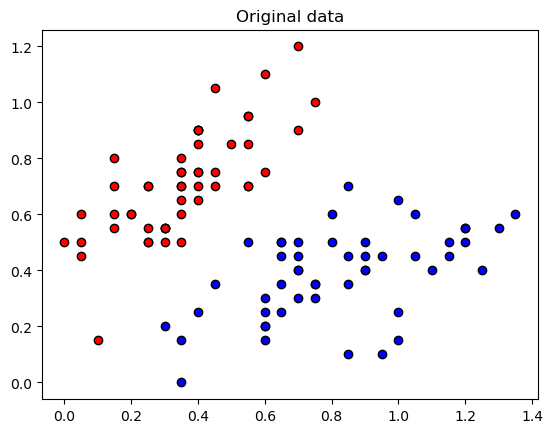

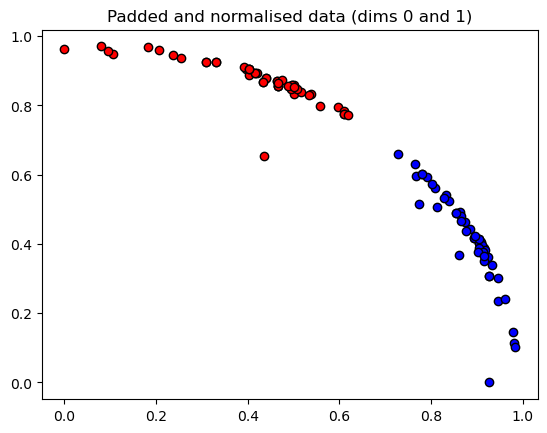

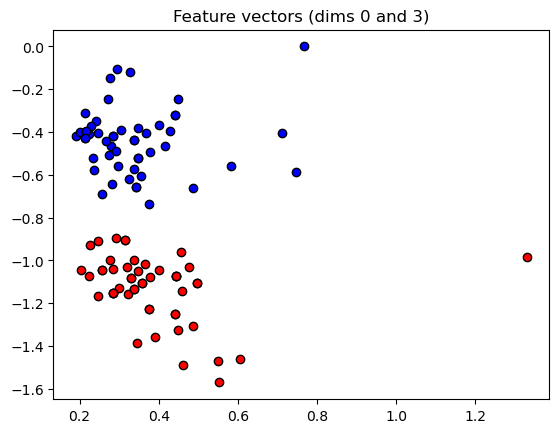

In [22]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="r", marker="o", ec="k")
plt.title("Original data")
plt.show()

plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(X_norm[:, dim1][Y == 1], X_norm[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X_norm[:, dim1][Y == -1], X_norm[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Padded and normalised data (dims {dim1} and {dim2})")
plt.show()

plt.figure()
dim1 = 0
dim2 = 3
plt.scatter(features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Feature vectors (dims {dim1} and {dim2})")
plt.show()

Similar to the previous problem, we can optimize the model to enable it to make predictions. In this step, we define some variables and use a portion of the data to train the circuit.

1. **Setting the Random Seed**: Ensures reproducibility by setting a fixed seed for the random number generator.
2. **Calculating Data Points**: Determines the total number of data points and calculates 75% of this number for training data.
3. **Generating Random Indices**: Creates a random permutation of indices to shuffle the data.
4. **Splitting Data**: Divides the data into training and validation sets using the shuffled indices.
5. **Preparing Data for Plotting**: Splits the original feature vectors into training and validation sets for consistent plotting.

This code effectively splits the dataset into training and validation sets in a reproducible and random manner.



In [23]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

1. **Setting the Number of Qubits and Layers**:
   - Specifies that the quantum circuit will use 2 qubits and have 6 layers.

2. **Initializing Weights**:
   - Generates a random array of weights with small values, scaled by 0.01, and sets them to require gradients for optimization.

3. **Initializing Bias**:
   - Creates a scalar bias with the value 0.0 and sets it to require gradients for optimization.

This code initializes the weights and bias for a quantum circuit, preparing them for gradient-based optimization during training.


In [24]:
num_qubits = 2
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

### **Optimization of the second problem**


1. **Initialize** the Nesterov Momentum Optimizer with a learning rate of 0.01.
2. **Set** the batch size to 5.
3. **Loop** for 100 iterations:
   - **Select** a random batch of training samples.
   - **Update** weights and bias using the optimizer.
   - **Make predictions** on training and validation sets.
   - **Calculate accuracy** for both sets.
   - **Log** the cost and accuracies every two iterations.

This code trains a variational classifier using batch gradient descent with Nesterov Momentum, evaluating performance on both training and validation sets.


In [25]:
opt = NesterovMomentumOptimizer(0.01)
batch_size = 5

# train the variational classifier
weights = weights_init
bias = bias_init
for it in range(100):
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = np.sign(variational_classifier(weights, bias, feats_train.T))
    predictions_val = np.sign(variational_classifier(weights, bias, feats_val.T))

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    if (it + 1) % 2 == 0:
        _cost = cost(weights, bias, features, Y)
        print(
            f"Iter: {it + 1:5d} | Cost: {_cost:0.7f} | "
            f"Acc train: {acc_train:0.7f} | Acc validation: {acc_val:0.7f}"
        )

Iter:     2 | Cost: 1.6589456 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:     4 | Cost: 1.2054273 | Acc train: 0.4933333 | Acc validation: 0.5600000
Iter:     6 | Cost: 0.9740740 | Acc train: 0.4933333 | Acc validation: 0.7200000
Iter:     8 | Cost: 0.9660872 | Acc train: 0.6400000 | Acc validation: 0.6400000
Iter:    10 | Cost: 0.9569019 | Acc train: 0.6000000 | Acc validation: 0.6000000
Iter:    12 | Cost: 0.9445863 | Acc train: 0.4933333 | Acc validation: 0.7200000
Iter:    14 | Cost: 1.0339978 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:    16 | Cost: 1.0774217 | Acc train: 0.4933333 | Acc validation: 0.5600000
Iter:    18 | Cost: 0.9984426 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:    20 | Cost: 0.8975279 | Acc train: 0.5600000 | Acc validation: 0.7600000
Iter:    22 | Cost: 0.8451699 | Acc train: 0.6400000 | Acc validation: 0.6400000
Iter:    24 | Cost: 0.8337489 | Acc train: 0.5600000 | Acc validation: 0.5200000
Iter:    26 | Cost: 0.783202


Once we train the model using the next cell, we can see how the variational classifier predicts. The plot’s center indicates the boundary between the classes.

1. **Initialize** a new figure and set the colormap.
2. **Create a grid** of points for decision regions.
3. **Preprocess** the grid points by adding padding, normalizing, and converting to new features.
4. **Predict** on the grid points using the variational classifier.
5. **Plot** the decision regions and add a contour line at the decision boundary.
6. **Plot** the training and validation data points with different colors and markers.
7. **Show** the plot with a legend.

This code visualizes the decision regions of a variational classifier along with the training and validation data points.



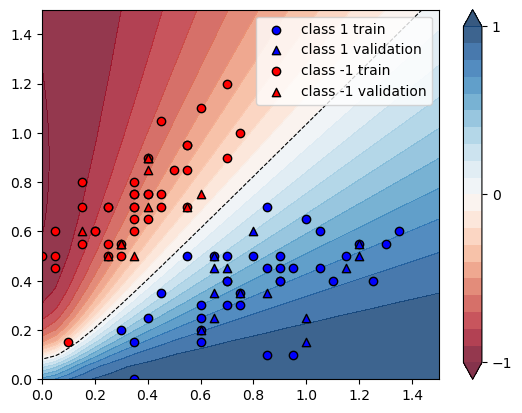

In [26]:
plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 30), np.linspace(0.0, 1.5, 30))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
padding = 0.1 * np.ones((len(X_grid), 2))
X_grid = np.c_[X_grid, padding]  # pad each input
normalization = np.sqrt(np.sum(X_grid**2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array([get_angles(x) for x in X_grid])  # angles are new features
predictions_grid = variational_classifier(weights, bias, features_grid.T)
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
levels = np.arange(-1, 1.1, 0.1)
cnt = plt.contourf(xx, yy, Z, levels=levels, cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
for color, label in zip(["b", "r"], [1, -1]):
    plot_x = X_train[:, 0][Y_train == label]
    plot_y = X_train[:, 1][Y_train == label]
    plt.scatter(plot_x, plot_y, c=color, marker="o", ec="k", label=f"class {label} train")
    plot_x = (X_val[:, 0][Y_val == label],)
    plot_y = (X_val[:, 1][Y_val == label],)
    plt.scatter(plot_x, plot_y, c=color, marker="^", ec="k", label=f"class {label} validation")

plt.legend()
plt.show()